In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF


import Bgolearn.BGOsampling as BGOS 

 Bgolearn : A Bayesian global optimization package 
 10 Jul 2022, version 1, Bin Cao, MGI, SHU, Shanghai, CHINA.


In [2]:
def True_function(X):
    X = np.array(X)
    Y = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8
    return Y

In [3]:
def generate_function(data, obs):
    print('------------12 original data-----------')
    data = np.array(data)
    # for one feature dataset
    data_matrix = np.array(data[:,0]).reshape(-1, 1)

    Measured_response = np.zeros(len(data_matrix))
    for i in range(obs):
        Measured_response += np.array(data[:,i+1])
    # for one feature dataset
    Measured_response = Measured_response/obs
    
    Measured_std = []
    for j in range(len(data_matrix)):
        std = np.std(np.array(data[j,1:1+obs]))
        Measured_std.append(std)
    Measured_std = np.array(Measured_std)  
    print('evaluated mean of y :', Measured_response)
    print('evaluated std of y :', Measured_std)
    print('---------------------------------------\n')
    return data_matrix,Measured_response,Measured_std

## design virtual samples

In [4]:
virtual_samples = np.linspace(0,11,100)

## define a callable Kriging model and sampling function

In [5]:
def Sam_function(X,real_std,obs):
    print('--------------Draw samples-------------')
    print('real std of added datum:', real_std)
    X = np.array(X)
    Y = np.zeros(1)
    Y_list = []
    for i in range(obs):
        __sam = 0.013*X**4 - 0.25*X**3 + 1.61*X**2 - 4.1*X + 8 + np.random.normal(loc=0.0, scale=real_std, size=None)
        Y_list.append(__sam)
        Y += __sam
        print(i+1,'-th sampling, result = ', __sam)
    cal_std = np.std(np.array(Y_list))
    print('evaluated mean of added datum:', Y/obs)
    print('evaluated std of added datum:', cal_std)
    print('---------------------------------------\n')
    return Y/obs, np.array(cal_std)


## instantiate Bgolearn

In [6]:
Bgolearn = BGOS.Bgolearn()
method_name = 'UCB'


------------12 original data-----------
evaluated mean of y : [6.21494888 5.56581958 4.61988109 4.34056442 4.35646479 4.67190767
 4.62173112 4.55605355 4.70138419 4.48867457 5.8769712  7.75473896]
evaluated std of y : [0.30008321 0.2742029  0.07394358 0.91538122 0.33136727 0.29720623
 0.07801782 0.48293232 0.24548787 0.12272781 0.21645983 0.25832216]
---------------------------------------

The next datum recomended by Upper confidence bound  : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.6148702744279944
2 -th sampling, result =  3.876610383615338
3 -th sampling, result =  3.7477960300783857
evaluated mean of added datum: [3.74642556]
evaluated std of added datum: 0.10685934626090561
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.7464])]


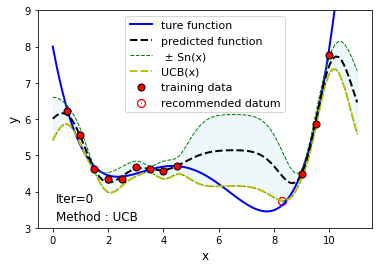

The next datum recomended by Upper confidence bound  : 
 x =  [7.88888889]
--------------Draw samples-------------
real std of added datum: 0.5
1 -th sampling, result =  3.5890345112535846
2 -th sampling, result =  3.322971838546304
3 -th sampling, result =  3.7034187260834184
evaluated mean of added datum: [3.53847503]
evaluated std of added datum: 0.1593782811939559
---------------------------------------

2-th iteration 
 new added datum: [7.9, array([3.5385])]


<Figure size 432x288 with 0 Axes>

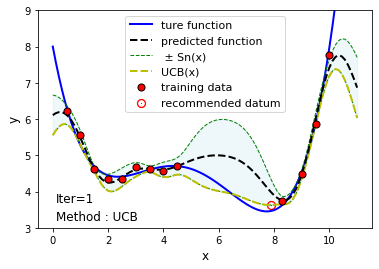

The next datum recomended by Upper confidence bound  : 
 x =  [7.22222222]
--------------Draw samples-------------
real std of added datum: 0.1
1 -th sampling, result =  3.624226808983856
2 -th sampling, result =  3.625361924147546
3 -th sampling, result =  3.5950740969749813
evaluated mean of added datum: [3.61488761]
evaluated std of added datum: 0.014017931289532054
---------------------------------------

3-th iteration 
 new added datum: [7.2, array([3.6149])]


<Figure size 432x288 with 0 Axes>

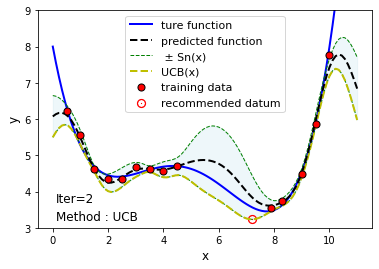

The next datum recomended by Upper confidence bound  : 
 x =  [7.66666667]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.404903557785298
2 -th sampling, result =  3.5887264949770423
3 -th sampling, result =  3.2978631541413153
evaluated mean of added datum: [3.43049774]
evaluated std of added datum: 0.12011568650087441
---------------------------------------

4-th iteration 
 new added datum: [7.7, array([3.4305])]


<Figure size 432x288 with 0 Axes>

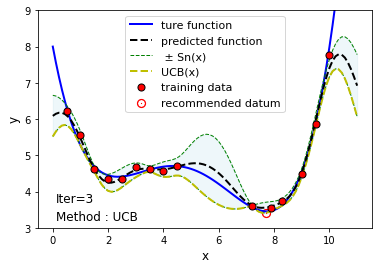

<Figure size 432x288 with 0 Axes>

In [8]:
obs = 3

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.UCB()
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.min()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.29185161 5.39856881 4.62623151 4.38385368 4.46148423 4.63694734
 4.5905237  4.59016103 4.67177078 4.4811777  5.95522378 7.80150911]
evaluated std of y : [0.29202661 0.37457828 0.06497479 0.79628133 0.33976528 0.26441507
 0.08652626 0.42238334 0.21869861 0.10707566 0.23132562 0.23792876]
---------------------------------------

The next datum recomended by Upper confidence bound  : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.75516353349825
2 -th sampling, result =  3.9714095718242044
3 -th sampling, result =  3.736179453170667
4 -th sampling, result =  3.5459041979006187
evaluated mean of added datum: [3.75216419]
evaluated std of added datum: 0.15072842272196169
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.7522])]


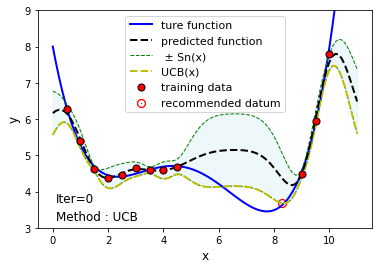

The next datum recomended by Upper confidence bound  : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.2
1 -th sampling, result =  3.741118721821284
2 -th sampling, result =  3.7068928235941128
3 -th sampling, result =  3.695426977852515
4 -th sampling, result =  3.6189214672160452
evaluated mean of added datum: [3.69059]
evaluated std of added datum: 0.04466180899880774
---------------------------------------

2-th iteration 
 new added datum: [8.3, array([3.6906])]


<Figure size 432x288 with 0 Axes>

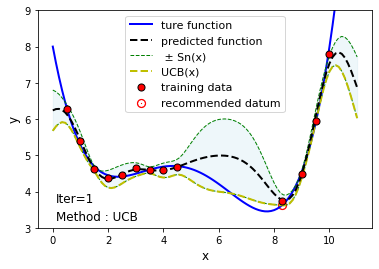

The next datum recomended by Upper confidence bound  : 
 x =  [7.77777778]
--------------Draw samples-------------
real std of added datum: 0.6
1 -th sampling, result =  2.8292722329731137
2 -th sampling, result =  3.260830892826292
3 -th sampling, result =  1.812280280252487
4 -th sampling, result =  2.657708476232252
evaluated mean of added datum: [2.64002297]
evaluated std of added datum: 0.5259963160852223
---------------------------------------

3-th iteration 
 new added datum: [7.8, array([2.64])]


<Figure size 432x288 with 0 Axes>

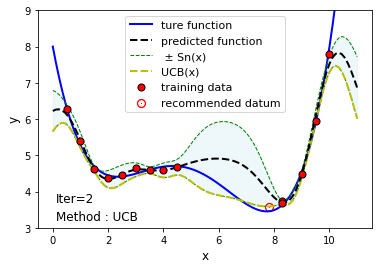

<Figure size 432x288 with 0 Axes>

In [9]:
obs = 4

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.UCB()
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.min()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break

------------12 original data-----------
evaluated mean of y : [6.38302126 5.47159103 4.62333861 4.45561327 4.45288222 4.66633633
 4.60958967 4.62022357 4.74050698 4.45448135 5.94232697 7.79008494]
evaluated std of y : [0.31854553 0.36548063 0.05840252 0.72653212 0.30438189 0.24369472
 0.0862756  0.38254565 0.23908561 0.10964916 0.20850551 0.21403299]
---------------------------------------

The next datum recomended by Upper confidence bound  : 
 x =  [8.33333333]
--------------Draw samples-------------
real std of added datum: 0.4
1 -th sampling, result =  3.6915755497063936
2 -th sampling, result =  4.0359812512299955
3 -th sampling, result =  3.509767426315225
4 -th sampling, result =  3.0291339212181643
5 -th sampling, result =  4.079448658504233
evaluated mean of added datum: [3.66918136]
evaluated std of added datum: 0.3843010388497396
---------------------------------------

1-th iteration 
 new added datum: [8.3, array([3.6692])]


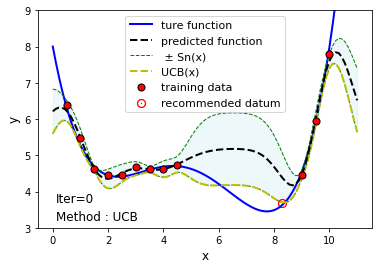

The next datum recomended by Upper confidence bound  : 
 x =  [8.22222222]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.400778243857522
2 -th sampling, result =  3.749292099192188
3 -th sampling, result =  3.5129953759254575
4 -th sampling, result =  3.317455226041452
5 -th sampling, result =  3.974955459607746
evaluated mean of added datum: [3.59109528]
evaluated std of added datum: 0.24065490623877334
---------------------------------------

2-th iteration 
 new added datum: [8.2, array([3.5911])]


<Figure size 432x288 with 0 Axes>

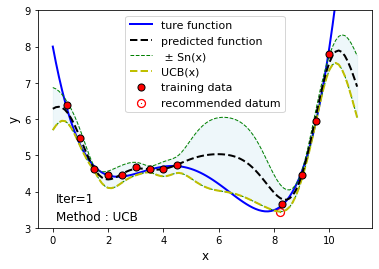

The next datum recomended by Upper confidence bound  : 
 x =  [8.22222222]
--------------Draw samples-------------
real std of added datum: 0.3
1 -th sampling, result =  3.2577534137008968
2 -th sampling, result =  3.7472468868136506
3 -th sampling, result =  3.4564104625423617
4 -th sampling, result =  3.8951179032436625
5 -th sampling, result =  3.643211396792959
evaluated mean of added datum: [3.59994801]
evaluated std of added datum: 0.22288746707309284
---------------------------------------

3-th iteration 
 new added datum: [8.2, array([3.5999])]


<Figure size 432x288 with 0 Axes>

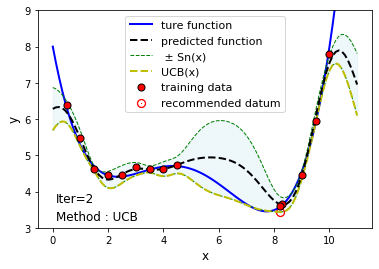

The next datum recomended by Upper confidence bound  : 
 x =  [7.66666667]
--------------Draw samples-------------
real std of added datum: 0.7
1 -th sampling, result =  2.891707526235794
2 -th sampling, result =  3.9702809125116123
3 -th sampling, result =  3.5874551448138914
4 -th sampling, result =  3.1783826899454093
5 -th sampling, result =  2.961703039864959
evaluated mean of added datum: [3.31790586]
evaluated std of added datum: 0.4065076161256597
---------------------------------------

4-th iteration 
 new added datum: [7.7, array([3.3179])]


<Figure size 432x288 with 0 Axes>

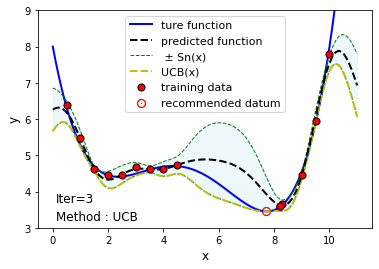

<Figure size 432x288 with 0 Axes>

In [10]:
obs = 5

data = pd.read_csv('data.csv')
data_matrix, Measured_response,Measured_std = generate_function(data,obs)
for i in range(500):
    plt.figure()
    ax1 = plt.subplot()
    ax1.set_ylim([3, 9])
    
   
    class Kriging_model(object):
        def fit_pre(self,xtrain,ytrain,xtest):
            # instantiated model
            kernel = RBF() 
            mdoel = GaussianProcessRegressor(kernel=kernel,normalize_y=True,alpha = Measured_std**2).fit(xtrain,ytrain)
            # defined the attribute's outputs
            mean,std = mdoel.predict(xtest,return_std=True)
            return mean,std  
    

    y_mean_pre,y_mean_std = Kriging_model().fit_pre(data_matrix, Measured_response, virtual_samples.reshape(-1,1))
    ax1.scatter(data_matrix,Measured_response,c='r',s=50,zorder=10,edgecolors=(0,0,0),label="training data")
    ax1.plot(virtual_samples,True_function(virtual_samples),'b',lw=2,label="ture function")
    ax1.plot(virtual_samples,y_mean_pre,'k--',lw=2,zorder=9,label="predicted function")
    ax1.fill_between(virtual_samples,y_mean_pre-y_mean_std,y_mean_pre+y_mean_std,alpha=0.2,color='lightblue')
    ax1.plot(virtual_samples,y_mean_pre-y_mean_std,'g--',lw=1,label=' ± Sn(x)') 
    ax1.plot(virtual_samples,y_mean_pre+y_mean_std,'g--',lw=1)

    
    Bgolearn = BGOS.Bgolearn()
    # min_search = False:  searching the global maximum
    model = Bgolearn.fit(Kriging_model,data_matrix,Measured_response,virtual_samples,opt_num = 1,min_search = True)
    # recall the utility function 
    _return = model.UCB()
    
    
    index = np.random.choice(np.flatnonzero(_return == _return.min()))
    recommend = virtual_samples[index]
    ax1.plot(virtual_samples,_return,'y--',lw=2,label='{name}(x)'.format(name = method_name))
    
    # give an intrinsic std to recommended datum
    sam_std = round(random.uniform(0.1,0.7),1)
    datum_y, datum_std = Sam_function(round(recommend,1),sam_std,obs)
    Measured_std = np.append(Measured_std,datum_std)
    data_matrix = np.append(data_matrix,np.round(recommend,1)).reshape(-1,1)
    Measured_response = np.append(Measured_response,np.round(datum_y,4))

    print("{num}-th iteration".format(num = i + 1),'\n', 'new added datum:',([np.round(recommend,1),np.round(datum_y,4)]))
    ax1.scatter(round(recommend,1),_return[index],c='red',s=1.5,linewidths=8,label="recommended datum") 
    
    
    plt.text(0.1,3.2,'Method : {name}'.format(name = method_name),fontsize=12,color='k')
    plt.text(0.1,3.7,'Iter={}'.format(i),fontsize=12,color='k')
    plt.xlabel('x',fontsize = 12)
    plt.ylabel('y',fontsize = 12)
    plt.legend(fontsize = 11)
    plt.savefig('{name}-obs_{obstime}-{num}.png'.format(name = method_name,obstime = obs,num = i),dpi=800)
    plt.show()
    plt.clf()
    if 7.6 <= round(recommend,1) <= 7.8:
        break
    elif i>=10:
        print('Searching is defeated')
        break